In [1]:
#!apt-get install default-jre
#!java -version

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from h2o.automl import H2OAutoML
import h2o

In [3]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\KSK\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\KSK\AppData\Local\Temp\tmppm8u6qq5
  JVM stdout: C:\Users\KSK\AppData\Local\Temp\tmppm8u6qq5\h2o_KSK_started_from_python.out
  JVM stderr: C:\Users\KSK\AppData\Local\Temp\tmppm8u6qq5\h2o_KSK_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.2
H2O_cluster_version_age:,1 month and 17 days
H2O_cluster_name:,H2O_from_python_KSK_1oy677
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.752 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KSK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
# The dataset was taken from the consumer financial corporationbureaue
df=pd.read_csv('C:/Users/KSK/Downloads/Banking projects/Dataset/consumer_complaints/consumer_compliants.csv')

In [7]:
df.head(2)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,4/3/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Fraudulent loan,This auto loan was opened on XX/XX/2020 in XXX...,Company has responded to the consumer and the ...,TRUIST FINANCIAL CORPORATION,PA,None,None,Consent provided,Web,4/3/2020,Closed with explanation,Yes,NaN,3591341
1,3/12/2020,Debt collection,Payday loan debt,Attempts to collect debt not owed,Debt is not yours,In XXXX of 2019 I noticed a debt for {$620.00}...,None,CURO Intermediate Holdings,CO,806XX,None,Consent provided,Web,3/12/2020,Closed with explanation,Yes,NaN,3564184


In [8]:
df1=df.copy()

In [9]:
df1['Product'].value_counts()

Debt collection                21772
Credit card or prepaid card    13193
Mortgage                        9799
Checking or savings account     7003
Student loan                    2950
Vehicle loan or lease           2736
Name: Product, dtype: int64

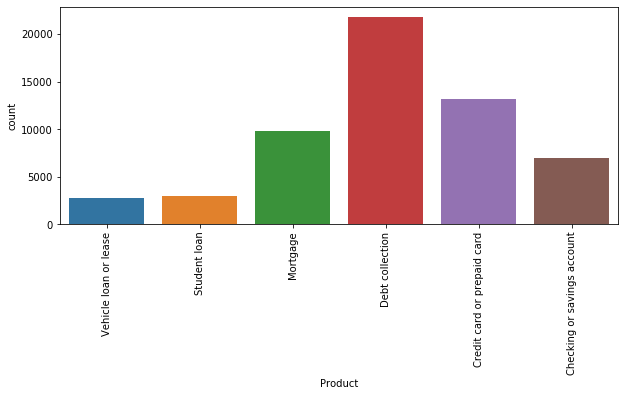

In [10]:
plt.figure(figsize=(10,4))
sns.countplot(df['Product'].sort_values(ascending=False))
plt.xticks(rotation=90)
plt.show()

In [11]:
# lets check the percentages of all the products
df1['Product'].isnull().sum()

0

In [12]:
list1=list(df1['Product'].unique())
for product in list1:
    print('The % of {} is'.format(product),round(len(df1[df1['Product']==product])/len(df1['Product']),2)*100)

The % of Vehicle loan or lease is 5.0
The % of Debt collection is 38.0
The % of Checking or savings account is 12.0
The % of Mortgage is 17.0
The % of Credit card or prepaid card is 23.0
The % of Student loan is 5.0


In this project we are trying to predict the type of the proddct base on the complaint registered so that we can route it to the agent and he can answer it better

## lets check at the company which company is having the most complaints

In [13]:
df1['Company'].value_counts()

CITIBANK, N.A.                                  3226
CAPITAL ONE FINANCIAL CORPORATION               2711
BANK OF AMERICA, NATIONAL ASSOCIATION           2580
JPMORGAN CHASE & CO.                            2409
WELLS FARGO & COMPANY                           2001
                                                ... 
Liberty Home Equity Solutions, Inc.                1
New Mexico Educational Assistance Foundation       1
William D. Meeker Enterprises, Inc.                1
Tormey Bewley Corporation                          1
Locate Source America, LLC                         1
Name: Company, Length: 2197, dtype: int64

In [14]:
complaints_df=df1[['Consumer complaint narrative','Product','Company']].rename(columns={'Consumer complaint narrative':'Consumer_complaint_narrative'})

In [15]:
complaints_df.head()

,Consumer_complaint_narrative,Product,Company
0,This auto loan was opened on XX/XX/2020 in XXX...,Vehicle loan or lease,TRUIST FINANCIAL CORPORATION
1,In XXXX of 2019 I noticed a debt for {$620.00}...,Debt collection,CURO Intermediate Holdings
2,"As stated from Capital One, XXXX XX/XX/XXXX an...",Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION
3,"Please see CFPB case XXXX. \n\nCapital One, in...",Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION
4,This debt was incurred due to medical malpract...,Debt collection,"Merchants and Professional Bureau, Inc."


In [16]:
pd.set_option('display.max_colwidth',-1)

In [17]:
complaints_df.head()

,Consumer_complaint_narrative,Product,Company
0,"This auto loan was opened on XX/XX/2020 in XXXX, NC with BB & T in my name. I have NEVER been to North Carolina and I have NEVER been a resident. I have filed a dispute twice through my credit bureaus but both times BB & T has claimed that this is an accurate loan. Which I wasn't aware of until today. I have tried to contact BB & T multiple times but I have never gotten through to a live person. I do n't drive and I have never owned a car before. I didn't have any knowledge of this account until I checked XXXXXXXX XXXX and noticed it. I've tried twice to dispute it. Additionally I never received any bills or information about this account. This is my last resort in trying to remove this fraudulent loan off of my account.",Vehicle loan or lease,TRUIST FINANCIAL CORPORATION
1,"In XXXX of 2019 I noticed a debt for {$620.00} on my credit which i believed was mine I thought speedy cash had bought one of my old debts and sold it to XXXX XXXX XXXX XXXX. I contacted XXXX XXXX XXXX XXXX and after several attempts of giving my full name, nothing came up in their system. I gave my social and the rep said the account popped up but DID NOT tell me that the account was under someone elses name and continued to let me make a payment. The payment was for {$120.00}. Confirmation number-XXXX. After realizing it was not my account, I called back to get my money back and inform them of the mistake. I was told i needed to mail them an FTC report and dispute letter to get my money back. I completed all of this and when i called again they said they transferred the account back to speedy cash for fraud review and I would need to contact them. After contacting them i was again told that i can not get my money back. The issue im having is this representative at XXXX XXXX played blind to obvious fraud and let an innocent person make a payment on someone elses debt and i want my money back.",Debt collection,CURO Intermediate Holdings
2,"As stated from Capital One, XXXX XX/XX/XXXX and XXXX 2018, My wife and I went to several car dealerships to request for a car loan to get a used car. However, according to their credit requirements unfortunately my credit score was insufficient for the car loan approval at that time. It seemed as though they pulled my credit report multiple times.",Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION
3,"Please see CFPB case XXXX. \n\nCapital One, in the letter they provided ( and attached to that case as their response ) said this : "" The funds were reversed and sent back to XXXX XXXX XXXX on XX/XX/XXXX ''. \n\nXXXX XXXX XXXX ( now XXXX XXXX ) has not received these funds. Staff at XXXX XXXX - and also staff at the account-holder 's business - have looked for return of my money ( {$650.00} ) and find nothing. \n\nCapital One needs to document - actually prove - they returned the funds, as stated in their letter. Capital One must provide electronic information, if the return was made that way, or document the paper check they sent back to XXXX XXXX. \n\nI've left 3 messages about this problem for the person who signed the letter ( XXXX ) from Capital One. I have received no call-backs. \n\nSummary : Capital One said they returned my money on XX/XX/XXXX : they did not. If they continue claim they did, then they need to prove that.",Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION
4,"This debt was incurred due to medical malpractice ( XXXX XXXX XXXX, XXXX, TX ). I asked the doctor to turn over my claim to his malpractice insurance company. This has cost me thousands of dollars to XXXX XXXX XXXX. I am still trying to collect damages from this doctor. He never responded and turned over me to collections Merchants and Professional Collection Bureau , Inc. I sent them a letter describing exactly this issue and instead of not contacting me and verifying my debt they start reporting this debt to the credit reporting agencies. They never verified the debt, like I as

In [18]:
df1['Product'].value_counts()

Debt collection                21772
Credit card or prepaid card    13193
Mortgage                       9799 
Checking or savings account    7003 
Student loan                   2950 
Vehicle loan or lease          2736 
Name: Product, dtype: int64

In [19]:
target={'Debt collection':0,'Credit card or prepaid card':1,'Mortgage':2,'Checking or savings account':3,'Student loan':4,'Vehicle loan or lease':5}

In [20]:
complaints_df['Product']=complaints_df['Product'].map(target)

In [21]:
complaints_df.head()

,Consumer_complaint_narrative,Product,Company
0,"This auto loan was opened on XX/XX/2020 in XXXX, NC with BB & T in my name. I have NEVER been to North Carolina and I have NEVER been a resident. I have filed a dispute twice through my credit bureaus but both times BB & T has claimed that this is an accurate loan. Which I wasn't aware of until today. I have tried to contact BB & T multiple times but I have never gotten through to a live person. I do n't drive and I have never owned a car before. I didn't have any knowledge of this account until I checked XXXXXXXX XXXX and noticed it. I've tried twice to dispute it. Additionally I never received any bills or information about this account. This is my last resort in trying to remove this fraudulent loan off of my account.",5,TRUIST FINANCIAL CORPORATION
1,"In XXXX of 2019 I noticed a debt for {$620.00} on my credit which i believed was mine I thought speedy cash had bought one of my old debts and sold it to XXXX XXXX XXXX XXXX. I contacted XXXX XXXX XXXX XXXX and after several attempts of giving my full name, nothing came up in their system. I gave my social and the rep said the account popped up but DID NOT tell me that the account was under someone elses name and continued to let me make a payment. The payment was for {$120.00}. Confirmation number-XXXX. After realizing it was not my account, I called back to get my money back and inform them of the mistake. I was told i needed to mail them an FTC report and dispute letter to get my money back. I completed all of this and when i called again they said they transferred the account back to speedy cash for fraud review and I would need to contact them. After contacting them i was again told that i can not get my money back. The issue im having is this representative at XXXX XXXX played blind to obvious fraud and let an innocent person make a payment on someone elses debt and i want my money back.",0,CURO Intermediate Holdings
2,"As stated from Capital One, XXXX XX/XX/XXXX and XXXX 2018, My wife and I went to several car dealerships to request for a car loan to get a used car. However, according to their credit requirements unfortunately my credit score was insufficient for the car loan approval at that time. It seemed as though they pulled my credit report multiple times.",5,CAPITAL ONE FINANCIAL CORPORATION
3,"Please see CFPB case XXXX. \n\nCapital One, in the letter they provided ( and attached to that case as their response ) said this : "" The funds were reversed and sent back to XXXX XXXX XXXX on XX/XX/XXXX ''. \n\nXXXX XXXX XXXX ( now XXXX XXXX ) has not received these funds. Staff at XXXX XXXX - and also staff at the account-holder 's business - have looked for return of my money ( {$650.00} ) and find nothing. \n\nCapital One needs to document - actually prove - they returned the funds, as stated in their letter. Capital One must provide electronic information, if the return was made that way, or document the paper check they sent back to XXXX XXXX. \n\nI've left 3 messages about this problem for the person who signed the letter ( XXXX ) from Capital One. I have received no call-backs. \n\nSummary : Capital One said they returned my money on XX/XX/XXXX : they did not. If they continue claim they did, then they need to prove that.",3,CAPITAL ONE FINANCIAL CORPORATION
4,"This debt was incurred due to medical malpractice ( XXXX XXXX XXXX, XXXX, TX ). I asked the doctor to turn over my claim to his malpractice insurance company. This has cost me thousands of dollars to XXXX XXXX XXXX. I am still trying to collect damages from this doctor. He never responded and turned over me to collections Merchants and Professional Collection Bureau , Inc. I sent them a letter describing exactly this issue and instead of not contacting me and verifying my debt they start reporting this debt to the credit reporting agencies. They never verified the debt, like I asked and they never stopped it from being reported when I specifically told them 

In [22]:
complaints_df.rename(columns={'Consumer_complaint_narrative':'complaints'},inplace=True)

In [23]:
complaints_df.head(1)

,complaints,Product,Company
0,"This auto loan was opened on XX/XX/2020 in XXXX, NC with BB & T in my name. I have NEVER been to North Carolina and I have NEVER been a resident. I have filed a dispute twice through my credit bureaus but both times BB & T has claimed that this is an accurate loan. Which I wasn't aware of until today. I have tried to contact BB & T multiple times but I have never gotten through to a live person. I do n't drive and I have never owned a car before. I didn't have any knowledge of this account until I checked XXXXXXXX XXXX and noticed it. I've tried twice to dispute it. Additionally I never received any bills or information about this account. This is my last resort in trying to remove this fraudulent loan off of my account.",5,TRUIST FINANCIAL CORPORATION


In [24]:
X_train,X_test=train_test_split(complaints_df,test_size=0.2,random_state=111)

## stemming

In [25]:
stemmer=nltk.stem.SnowballStemmer('english')

## downloading stopwords

In [26]:
nltk.download('stopwords')
stop_words=set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KSK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [52]:
## lets write the function for tokenize the sentences
def tokenize(text):
    tokens=[word for word in nltk.word_tokenize(text) if(len(word)>3 and len(word.strip('Xx/'))>2 and len(re.sub('\d+', '',word.strip('Xx/')))>=2)]
    tokens=map(str.lower,tokens)
    stems=[stemmer.stem(item) for item in tokens if (item not in stop_words)]
    return stems

In [54]:
vectorizer_tf=TfidfVectorizer(tokenizer=tokenize,stop_words=None,max_df=0.75,max_features=1000,lowercase=False,ngram_range=(1,2))
train_vectors=vectorizer_tf.fit_transform(X_train.complaints)

In [56]:
train_vectors.A

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05982332, 0.        , ..., 0.        , 0.        ,
        0.04799062],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.09582677],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [58]:
vectorizer_tf.get_feature_names()

['abil',
 'abl',
 'absolut',
 'abus',
 'accept',
 'access',
 'access account',
 'accord',
 'account',
 'account account',
 'account balanc',
 'account bank',
 'account call',
 'account close',
 'account credit',
 'account inform',
 'account number',
 'account open',
 'account report',
 'account would',
 'accru',
 'acct',
 'accur',
 'acknowledg',
 'act',
 'action',
 'activ',
 'actual',
 'ad',
 'addit',
 'address',
 'adjust',
 'admit',
 'advanc',
 'advantag',
 'advertis',
 'advis',
 'affect',
 'affidavit',
 'afford',
 'agenc',
 'agent',
 'agre',
 'agreement',
 'alert',
 'alleg',
 'alleg debt',
 'alli',
 'allow',
 'almost',
 'along',
 'alreadi',
 'also',
 'although',
 'alway',
 'america',
 'american',
 'american express',
 'amex',
 'amount',
 'amount owe',
 'and/or',
 'annual',
 'anoth',
 'answer',
 'anyon',
 'anyth',
 'apart',
 'appar',
 'appeal',
 'appear',
 'appli',
 'applic',
 'apprais',
 'appreci',
 'approv',
 'approxim',
 'around',
 'arrang',
 'arriv',
 'ask',
 'assess',
 'assign',


In [60]:
test_vectors=vectorizer_tf.fit_transform(X_test.complaints)

In [61]:
X_train.shape

(45962, 3)

In [ ]:
X_train.rename(columns={'Product':'target'},inplace=True)

In [65]:
train_df=pd.DataFrame(train_vectors.toarray(),columns=vectorizer_tf.get_feature_names())
train_df=pd.concat([train_df,X_train['target'].reset_index(drop=True)],axis=1)

In [66]:
train_df.head()

,abil,abl,absolut,abus,accept,access,accord,account,account account,account balanc,...,would like,would need,would receiv,would take,write,written,wrong,wrote,year,target
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.012890,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3
1,0.0,0.059823,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047991,0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.031230,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.127589,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3


In [67]:
X_test.rename(columns={'Product':'target'},inplace=True)

In [68]:
test_df=pd.DataFrame(test_vectors.toarray(),columns=vectorizer_tf.get_feature_names())
test_df=pd.concat([test_df,X_test['target'].reset_index(drop=True)],axis=1)

In [69]:
test_df.head()

,abil,abl,absolut,abus,accept,access,accord,account,account account,account balanc,...,would like,would need,would receiv,would take,write,written,wrong,wrote,year,target
0,0.0,0.089713,0.0,0.0,0.0,0.219842,0.0,0.360115,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,3
1,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.125347,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,2
2,0.0,0.143522,0.0,0.0,0.0,0.000000,0.0,0.216041,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1
3,0.0,0.088031,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.044989,0.0,0.0,0.0,0.0,0.0,0.071252,4
4,0.0,0.079757,0.0,0.0,0.0,0.000000,0.0,0.040019,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.129110,1


In [71]:
test_df.shape,train_df.shape

((11491, 1001), (45962, 1001))

## coverting the pandas dataframe into h20 data frame

In [72]:
h2o_train_df=h2o.H2OFrame(train_df)
h2o_test_df=h2o.H2OFrame(test_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [73]:
h2o_train_df.types

{'abil': 'real',
 'abl': 'real',
 'absolut': 'real',
 'abus': 'real',
 'accept': 'real',
 'access': 'real',
 'accord': 'real',
 'account': 'real',
 'account account': 'real',
 'account balanc': 'real',
 'account bank': 'real',
 'account call': 'real',
 'account close': 'real',
 'account credit': 'real',
 'account inform': 'real',
 'account number': 'real',
 'account open': 'real',
 'account report': 'real',
 'account would': 'real',
 'accru': 'real',
 'acct': 'real',
 'accur': 'real',
 'acknowledg': 'real',
 'act': 'real',
 'action': 'real',
 'activ': 'real',
 'actual': 'real',
 'ad': 'real',
 'addit': 'real',
 'address': 'real',
 'adjust': 'real',
 'admit': 'real',
 'advanc': 'real',
 'advantag': 'real',
 'advertis': 'real',
 'advis': 'real',
 'affect': 'real',
 'affidavit': 'real',
 'afford': 'real',
 'agenc': 'real',
 'agent': 'real',
 'agre': 'real',
 'agreement': 'real',
 'ahead': 'real',
 'alert': 'real',
 'alleg': 'real',
 'alleg debt': 'real',
 'alli': 'real',
 'allow': 'real',

## converting the target column from integer type to enumeration type so that it can understand the problem is classification


In [74]:
h2o_train_df['target']=h2o_train_df['target'].asfactor()
h2o_test_df['target']=h2o_test_df['target'].asfactor()

## lets set the h2o automl pipeline

In [75]:
# base pipeline i.e; im not doing any cross validation because its a base model
aml=H2OAutoML(max_models=10,seed=10,exclude_algos=["StackedEnsemble"],verbosity="info",nfolds=0,balance_classes=True,max_after_balance_size=0.3)

In [77]:
x=vectorizer_tf.get_feature_names()
y='target'

In [78]:
aml.train(x=x,y=y,training_frame=h2o_train_df,validation_frame=h2o_test_df)

AutoML progress: |
12:57:25.448: Project: AutoML_20210104_125725431
12:57:25.453: Cross-validation disabled by user: no fold column nor nfolds > 1.
12:57:25.454: Setting stopping tolerance adaptively based on the training frame: 0.00466445106034528
12:57:25.454: Build control seed: 10
12:57:25.454: Since cross-validation is disabled, and no leaderboard frame was provided, automatically split the training data into training and leaderboard frames in the ratio 90/10
12:57:28.779: training frame: Frame key: automl_training_py_1_sid_8d9e    cols: 1001    rows: 41254  chunks: 53    size: 34321302  checksum: 7287183896314316582
12:57:28.782: validation frame: Frame key: py_2_sid_8d9e    cols: 1001    rows: 11491  chunks: 14    size: 9659665  checksum: -876062871211588342
12:57:28.841: leaderboard frame: Frame key: automl_leaderboard_py_1_sid_8d9e    cols: 1001    rows: 4708  chunks: 53    size: 7585668  checksum: -1347584539648230020
12:57:28.841: blending frame: NULL
12:57:28.841: response 

## lets look at the leader board

In [79]:
aml.leaderboard

model_id,mean_per_class_error,logloss,rmse,mse
GBM_grid__1_AutoML_20210104_125725_model_1,0.161815,0.406128,0.343225,0.117803
GBM_3_AutoML_20210104_125725,0.163364,0.404864,0.344534,0.118704
GBM_2_AutoML_20210104_125725,0.164016,0.394504,0.342739,0.11747
GBM_5_AutoML_20210104_125725,0.165586,0.385939,0.334485,0.11188
GBM_4_AutoML_20210104_125725,0.176197,0.415487,0.352784,0.124456
GBM_1_AutoML_20210104_125725,0.18506,0.429403,0.361738,0.130854
DeepLearning_1_AutoML_20210104_125725,0.195632,0.609525,0.380502,0.144782
GLM_1_AutoML_20210104_125725,0.208258,0.451622,0.378615,0.143349
XRT_1_AutoML_20210104_125725,0.27982,0.585285,0.438601,0.192371
DRF_1_AutoML_20210104_125725,0.289641,0.59351,0.443302,0.196517


## predictions

In [80]:
pred=aml.leader.predict(h2o_test_df)

gbm prediction progress: |████████████████████████████████████████████████| 100%


## model Performance

In [81]:
aml.leader.model_performance(h2o_test_df)


ModelMetricsMultinomial: gbm
** Reported on test data. **

MSE: 0.45340561220558623
RMSE: 0.6733540021456665
LogLoss: 1.4590282732974522
Mean Per-Class Error: 0.6138708308646944

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,2913.0,720.0,269.0,91.0,131.0,171.0,0.321769,"1,382 / 4,295"
1,988.0,1162.0,92.0,152.0,96.0,93.0,0.550136,"1,421 / 2,583"
2,640.0,325.0,734.0,70.0,117.0,129.0,0.635732,"1,281 / 2,015"
3,444.0,520.0,69.0,323.0,62.0,43.0,0.778919,"1,138 / 1,461"
4,184.0,72.0,26.0,29.0,285.0,15.0,0.533552,326 / 611
5,218.0,116.0,40.0,40.0,40.0,72.0,0.863118,454 / 526
6,5387.0,2915.0,1230.0,705.0,731.0,523.0,0.522322,"6,002 / 11,491"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.477678
1,2,0.707075
2,3,0.839962
3,4,0.926029
4,5,0.977635
5,6,1.000000


## lets look at the h2o leader hyper parameters 

In [82]:
model_ids=list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
out=h2o.get_model([mid for mid in model_ids if 'GBM' in mid][0])

In [83]:
out

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid__1_AutoML_20210104_125725_model_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,60.0,360.0,673459.0,16.0,16.0,16.0,25.0,381.0,141.00278




ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.0367392780148171
RMSE: 0.19167492797655383
LogLoss: 0.133216799468025
Mean Per-Class Error: 0.025440205992172348

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,2053.0,1.0,0.0,0.0,0.0,0.0,0.000487,"1 / 2,054"
1,19.0,2078.0,0.0,0.0,1.0,0.0,0.009533,"20 / 2,098"
2,1.0,11.0,2037.0,0.0,0.0,0.0,0.005857,"12 / 2,049"
3,4.0,1.0,0.0,2048.0,0.0,0.0,0.002435,"5 / 2,053"
4,62.0,41.0,0.0,0.0,1959.0,0.0,0.049952,"103 / 2,062"
5,114.0,59.0,1.0,0.0,1.0,1899.0,0.084378,"175 / 2,074"
6,2253.0,2191.0,2038.0,2048.0,1961.0,1899.0,0.025504,"316 / 12,390"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.974496
1,2,0.992252
2,3,0.998144
3,4,0.999516
4,5,1.000000
5,6,1.000000



ModelMetricsMultinomial: gbm
** Reported on validation data. **

MSE: 0.45340561220558623
RMSE: 0.6733540021456665
LogLoss: 1.4590282732974522
Mean Per-Class Error: 0.6138708308646944

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,2913.0,720.0,269.0,91.0,131.0,171.0,0.321769,"1,382 / 4,295"
1,988.0,1162.0,92.0,152.0,96.0,93.0,0.550136,"1,421 / 2,583"
2,640.0,325.0,734.0,70.0,117.0,129.0,0.635732,"1,281 / 2,015"
3,444.0,520.0,69.0,323.0,62.0,43.0,0.778919,"1,138 / 1,461"
4,184.0,72.0,26.0,29.0,285.0,15.0,0.533552,326 / 611
5,218.0,116.0,40.0,40.0,40.0,72.0,0.863118,454 / 526
6,5387.0,2915.0,1230.0,705.0,731.0,523.0,0.522322,"6,002 / 11,491"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.477678
1,2,0.707075
2,3,0.839962
3,4,0.926029
4,5,0.977635
5,6,1.000000



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,validation_rmse,validation_logloss,validation_classification_error
0,,2021-01-04 13:31:12,0.056 sec,0.0,0.841328,2.057040,0.834221,0.764860,1.568494,0.626229
1,,2021-01-04 13:32:11,58.850 sec,5.0,0.633532,1.089558,0.410815,0.709860,1.386593,0.545905
2,,2021-01-04 13:33:08,1 min 55.795 sec,10.0,0.500463,0.722102,0.164326,0.695166,1.351407,0.526238
3,,2021-01-04 13:34:02,2 min 49.541 sec,15.0,0.407343,0.516601,0.108797,0.677593,1.330531,0.507876
4,,2021-01-04 13:34:53,3 min 40.819 sec,20.0,0.345058,0.393360,0.085876,0.668732,1.329584,0.494474
5,,2021-01-04 13:35:42,4 min 29.712 sec,25.0,0.303802,0.313661,0.070056,0.668131,1.349184,0.500740
6,,2021-01-04 13:36:29,5 min 16.219 sec,30.0,0.275928,0.261051,0.059645,0.669096,1.372501,0.505961
7,,2021-01-04 13:37:12,5 min 59.735 sec,35.0,0.252714,0.221133,0.049395,0.670151,1.395554,0.511270
8,,2021-01-04 13:37:53,6 min 40.503 sec,40.0,0.235804,0.194033,0.041001,0.670367,1.405295,0.514751
9,,2021-01-04 13:38:35,7 min 22.196 sec,45.0,0.221374,0.172789,0.035270,0.671317,1.417043,0.514925



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,mortgag compani,3296.777344,1.000000,0.086425
1,card account,2662.283936,0.807541,0.069792
2,student,2494.258301,0.756575,0.065387
3,day later,2283.687744,0.692703,0.059867
4,loan modif,1483.408936,0.449957,0.038888
5,valu,1332.594971,0.404211,0.034934
6,bank account,1238.425049,0.375647,0.032465
7,near,1098.891602,0.333323,0.028807
8,deliv,1085.311157,0.329204,0.028451
9,past,934.738586,0.283531,0.024504



See the whole table with table.as_data_frame()


In [86]:
out.convert_H2OXGBoostParams_2_XGBoostParams

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid__1_AutoML_20210104_125725_model_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,60.0,360.0,673459.0,16.0,16.0,16.0,25.0,381.0,141.00278




ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.0367392780148171
RMSE: 0.19167492797655383
LogLoss: 0.133216799468025
Mean Per-Class Error: 0.025440205992172348

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,2053.0,1.0,0.0,0.0,0.0,0.0,0.000487,"1 / 2,054"
1,19.0,2078.0,0.0,0.0,1.0,0.0,0.009533,"20 / 2,098"
2,1.0,11.0,2037.0,0.0,0.0,0.0,0.005857,"12 / 2,049"
3,4.0,1.0,0.0,2048.0,0.0,0.0,0.002435,"5 / 2,053"
4,62.0,41.0,0.0,0.0,1959.0,0.0,0.049952,"103 / 2,062"
5,114.0,59.0,1.0,0.0,1.0,1899.0,0.084378,"175 / 2,074"
6,2253.0,2191.0,2038.0,2048.0,1961.0,1899.0,0.025504,"316 / 12,390"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.974496
1,2,0.992252
2,3,0.998144
3,4,0.999516
4,5,1.000000
5,6,1.000000



ModelMetricsMultinomial: gbm
** Reported on validation data. **

MSE: 0.45340561220558623
RMSE: 0.6733540021456665
LogLoss: 1.4590282732974522
Mean Per-Class Error: 0.6138708308646944

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,2913.0,720.0,269.0,91.0,131.0,171.0,0.321769,"1,382 / 4,295"
1,988.0,1162.0,92.0,152.0,96.0,93.0,0.550136,"1,421 / 2,583"
2,640.0,325.0,734.0,70.0,117.0,129.0,0.635732,"1,281 / 2,015"
3,444.0,520.0,69.0,323.0,62.0,43.0,0.778919,"1,138 / 1,461"
4,184.0,72.0,26.0,29.0,285.0,15.0,0.533552,326 / 611
5,218.0,116.0,40.0,40.0,40.0,72.0,0.863118,454 / 526
6,5387.0,2915.0,1230.0,705.0,731.0,523.0,0.522322,"6,002 / 11,491"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.477678
1,2,0.707075
2,3,0.839962
3,4,0.926029
4,5,0.977635
5,6,1.000000



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,validation_rmse,validation_logloss,validation_classification_error
0,,2021-01-04 13:31:12,0.056 sec,0.0,0.841328,2.057040,0.834221,0.764860,1.568494,0.626229
1,,2021-01-04 13:32:11,58.850 sec,5.0,0.633532,1.089558,0.410815,0.709860,1.386593,0.545905
2,,2021-01-04 13:33:08,1 min 55.795 sec,10.0,0.500463,0.722102,0.164326,0.695166,1.351407,0.526238
3,,2021-01-04 13:34:02,2 min 49.541 sec,15.0,0.407343,0.516601,0.108797,0.677593,1.330531,0.507876
4,,2021-01-04 13:34:53,3 min 40.819 sec,20.0,0.345058,0.393360,0.085876,0.668732,1.329584,0.494474
5,,2021-01-04 13:35:42,4 min 29.712 sec,25.0,0.303802,0.313661,0.070056,0.668131,1.349184,0.500740
6,,2021-01-04 13:36:29,5 min 16.219 sec,30.0,0.275928,0.261051,0.059645,0.669096,1.372501,0.505961
7,,2021-01-04 13:37:12,5 min 59.735 sec,35.0,0.252714,0.221133,0.049395,0.670151,1.395554,0.511270
8,,2021-01-04 13:37:53,6 min 40.503 sec,40.0,0.235804,0.194033,0.041001,0.670367,1.405295,0.514751
9,,2021-01-04 13:38:35,7 min 22.196 sec,45.0,0.221374,0.172789,0.035270,0.671317,1.417043,0.514925



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,mortgag compani,3296.777344,1.000000,0.086425
1,card account,2662.283936,0.807541,0.069792
2,student,2494.258301,0.756575,0.065387
3,day later,2283.687744,0.692703,0.059867
4,loan modif,1483.408936,0.449957,0.038888
5,valu,1332.594971,0.404211,0.034934
6,bank account,1238.425049,0.375647,0.032465
7,near,1098.891602,0.333323,0.028807
8,deliv,1085.311157,0.329204,0.028451
9,past,934.738586,0.283531,0.024504



See the whole table with table.as_data_frame()


<bound method H2OEstimator.convert_H2OXGBoostParams_2_XGBoostParams of >

## from the above autmoml it was observed that gbm performed well so i am selecting the gbm as base model

In [87]:
import xgboost as xgb
from sklearn.metrics import classification_report,confusion_matrix

In [104]:
xgb_clf=xgb.XGBClassifier( n_estimators=100,learning_rate=0.05,max_depth=6,objective='multi:softprob',random_state=10)

In [106]:
xgb_clf.fit(train_vectors,X_train['target'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=10, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [107]:
predictions=xgb_clf.predict(test_vectors)

In [108]:
cm=confusion_matrix(X_test['target'],predictions)

In [109]:
print(cm)

[[3463  340  104   88  157  143]
 [1135 1098   66   99  120   65]
 [ 955  166  591   34  130  139]
 [ 793  256   54  202   98   58]
 [ 347   47   20   23  158   16]
 [ 343   58   18   27   44   36]]


In [110]:
print('classification report :\n',classification_report(X_test['target'],predictions))

classification report :
               precision    recall  f1-score   support

           0       0.49      0.81      0.61      4295
           1       0.56      0.43      0.48      2583
           2       0.69      0.29      0.41      2015
           3       0.43      0.14      0.21      1461
           4       0.22      0.26      0.24       611
           5       0.08      0.07      0.07       526

    accuracy                           0.48     11491
   macro avg       0.41      0.33      0.34     11491
weighted avg       0.50      0.48      0.45     11491



In [111]:
from sklearn.utils import class_weight

In [112]:
class_weights=list(class_weight.compute_class_weight('balanced',np.unique(X_train['target']),X_train['target']))

In [113]:
class_weights

[0.43830939711239536,
 0.7219918316054037,
 0.9841127098321343,
 1.382232647660291,
 3.275046316089497,
 3.466214177978884]

In [114]:
weights=np.ones(X_train.shape[0],dtype='float')

In [115]:
weights

array([1., 1., 1., ..., 1., 1., 1.])

In [116]:
for i,val in enumerate(X_train['target']):
    weights[i]=class_weights[val]

In [117]:
weights

array([1.38223265, 0.4383094 , 0.4383094 , ..., 0.72199183, 0.72199183,
       0.98411271])

In [120]:
xgb_clf=xgb.XGBClassifier( n_estimators=100,learning_rate=0.05,max_depth=6,objective='multi:softprob',random_state=10)

In [121]:
xgb_clf.fit(train_vectors,X_train['target'],sample_weight=weights)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=10, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [122]:
predictions=xgb_clf.predict(test_vectors)

In [123]:
cm=confusion_matrix(X_test['target'],predictions)

In [124]:
print(cm)

[[2073  694  312  213  276  727]
 [ 608 1190  115  208  158  304]
 [ 488  258  606   89  246  328]
 [ 375  390   72  361  114  149]
 [ 120   40   28   13  357   53]
 [ 164   59   41   34   48  180]]


In [125]:
print('classification report :\n',classification_report(X_test['target'],predictions))

classification report :
               precision    recall  f1-score   support

           0       0.54      0.48      0.51      4295
           1       0.45      0.46      0.46      2583
           2       0.52      0.30      0.38      2015
           3       0.39      0.25      0.30      1461
           4       0.30      0.58      0.39       611
           5       0.10      0.34      0.16       526

    accuracy                           0.41     11491
   macro avg       0.38      0.40      0.37     11491
weighted avg       0.47      0.41      0.43     11491

